# Setting Up the Problem

#### Objective: Understand and establish the baseline for your chosen dataset

In [1]:
import datasets
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## OWN FUNCTIONS
import support_functions
from support_functions import *

In [2]:
df = load_dataset("carblacac/twitter-sentiment-analysis")

/Users/mikelgallo/anaconda3/envs/text_2/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for carblacac/twitter-sentiment-analysis contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/carblacac/twitter-sentiment-analysis
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


### Characteristics of the dataset

**b. Dataset Description (0.5 points): Provide a brief overview of your dataset, including size, class distribution, and any peculiar characteristics. Include basic descriptive statistics.**

##### TSATC: Twitter Sentiment Analysis Training Corpus     
Original DATASET contains 1,578,627 classified tweets (1 for positive and 0 for negative sentiment).

Our dataset has already been randomly sampled, cleaned, and split into training and testing sets. Both positive and negative classes are well balanced within each subset, and the training subset has been further divided into an 80% training set and a 20% validation set.

Source: https://github.com/cblancac/SentimentAnalysisBert/blob/main/data  
  
Languages: English

In [3]:
## Defining train, validation and test sets
train_data = df['train']['text']
train_labels = df['train']['feeling']

df_train = pd.DataFrame({'text':train_data,'label':train_labels})

validation_data = df['validation']['text']
validation_labels = df['validation']['feeling']

test_data = df['test']['text']
test_labels = df['test']['feeling']

df

DatasetDict({
    train: Dataset({
        features: ['text', 'feeling'],
        num_rows: 119988
    })
    validation: Dataset({
        features: ['text', 'feeling'],
        num_rows: 29997
    })
    test: Dataset({
        features: ['text', 'feeling'],
        num_rows: 61998
    })
})

### Dataset size

In [4]:
total_rows = len(train_labels) + len(test_labels) + len(validation_labels)
# Calculate train size including validation
Train_size = len(train_labels) + len(validation_labels)
# Calculate Summary
summary_df = pd.DataFrame({'SET': ['TRAIN','TEST', 'TOTAL'], 'ROWS': [Train_size, len(test_labels), total_rows], 'SPLIT': [Train_size/total_rows, len(test_labels)/total_rows,total_rows/total_rows]})
print('Dataset Split [TRAIN, TEST]')
display(summary_df.round(3))

## TRAIN SPLIT
summary_df_train = pd.DataFrame({'SET': ['train','validation', 'TRAIN'], 'ROWS': [len(train_labels), len(validation_labels), Train_size], 'SPLIT': [len(train_labels)/Train_size, len(validation_labels)/Train_size,Train_size/Train_size]})
print('TRAIN Split [train, validation]')
display(summary_df_train.round(3))

Dataset Split [TRAIN, TEST]


,SET,ROWS,SPLIT
0,TRAIN,149985,0.708
1,TEST,61998,0.292
2,TOTAL,211983,1.000


TRAIN Split [train, validation]


,SET,ROWS,SPLIT
0,train,119988,0.8
1,validation,29997,0.2
2,TRAIN,149985,1.0


### Class distribution

In [5]:
## Class balance of our datasets
print('train')
class_prop(train_labels)
print('validation')
class_prop(validation_labels)
print('test')
class_prop(test_labels)

train
   class  count    perc
0      1  60019  0.5002
1      0  59969  0.4998
validation
   class  count    perc
0      0  15050  0.5017
1      1  14947  0.4983
test
   class  count    perc
0      1  31029  0.5005
1      0  30969  0.4995


### Distribution of text lengths (train set only)

In [6]:
df_train['text_length']= [len(i.split()) for i in df_train['text']]
#Calculating Answer Length

In [7]:
for i in df_train['text'][0:5]:
    print(i.split(),'length: ', len(i.split()) )

['@fa6ami86', 'so', 'happy', 'that', 'salman', 'won.', 'btw', 'the', '14sec', 'clip', 'is', 'truely', 'a', 'teaser'] length:  14
['@phantompoptart', '.......oops....', 'I', 'guess', "I'm", 'kinda', 'out', 'of', 'it....', 'Blonde', 'moment', '-blushes-', 'epic', 'fail'] length:  14
['@bradleyjp', 'decidedly', 'undecided.', 'Depends', 'on', 'the', 'situation.', 'When', "I'm", 'out', 'with', 'the', 'people', "I'll", 'be', 'in', 'Chicago', 'with?', 'Maybe.'] length:  19
['@Mountgrace', 'lol', 'i', 'know!', 'its', 'so', 'frustrating', 'isnt', 'it?!'] length:  9
['@kathystover', "Didn't", 'go', 'much', 'of', 'any', 'where', '-', 'Life', 'took', 'over', 'for', 'a', 'while'] length:  14


Summary Statistics of text_length for positive(1) and negative(0) tweets
            mean  median       std  min  max
label                                       
0      13.730761    13.0  7.035053    1   57
1      12.862760    12.0  6.810572    1  111
   
Plot text_length distribution for positive(1) and negative(0) tweets


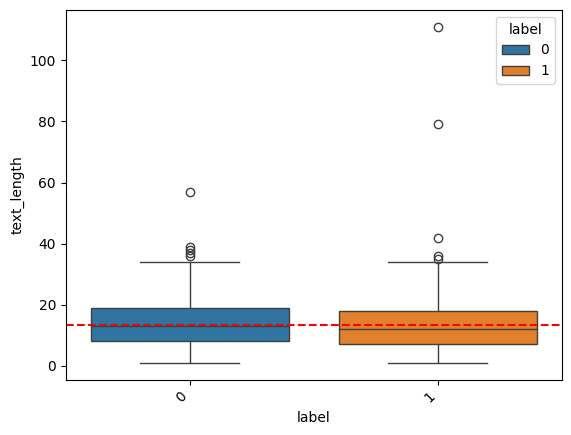

In [8]:
## SUmmary statistics for text_length
# Calculate multiple statistics
print('Summary Statistics of text_length for positive(1) and negative(0) tweets')
statistics = df_train.groupby('label')['text_length'].agg(['mean', 'median','std', 'min', 'max'])
# Display the result
print(statistics)

print('   ')

print('Plot text_length distribution for positive(1) and negative(0) tweets')
sns.boxplot(data=df_train, x='label', y='text_length',hue = 'label')
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_train['text_length'].mean()
plt.axhline(y=mean_reply_length, color='red', linestyle='--', label=f'Mean text Length ({mean_reply_length:.2f})')
# Show the plot
plt.show()

## Random Classifier Performance

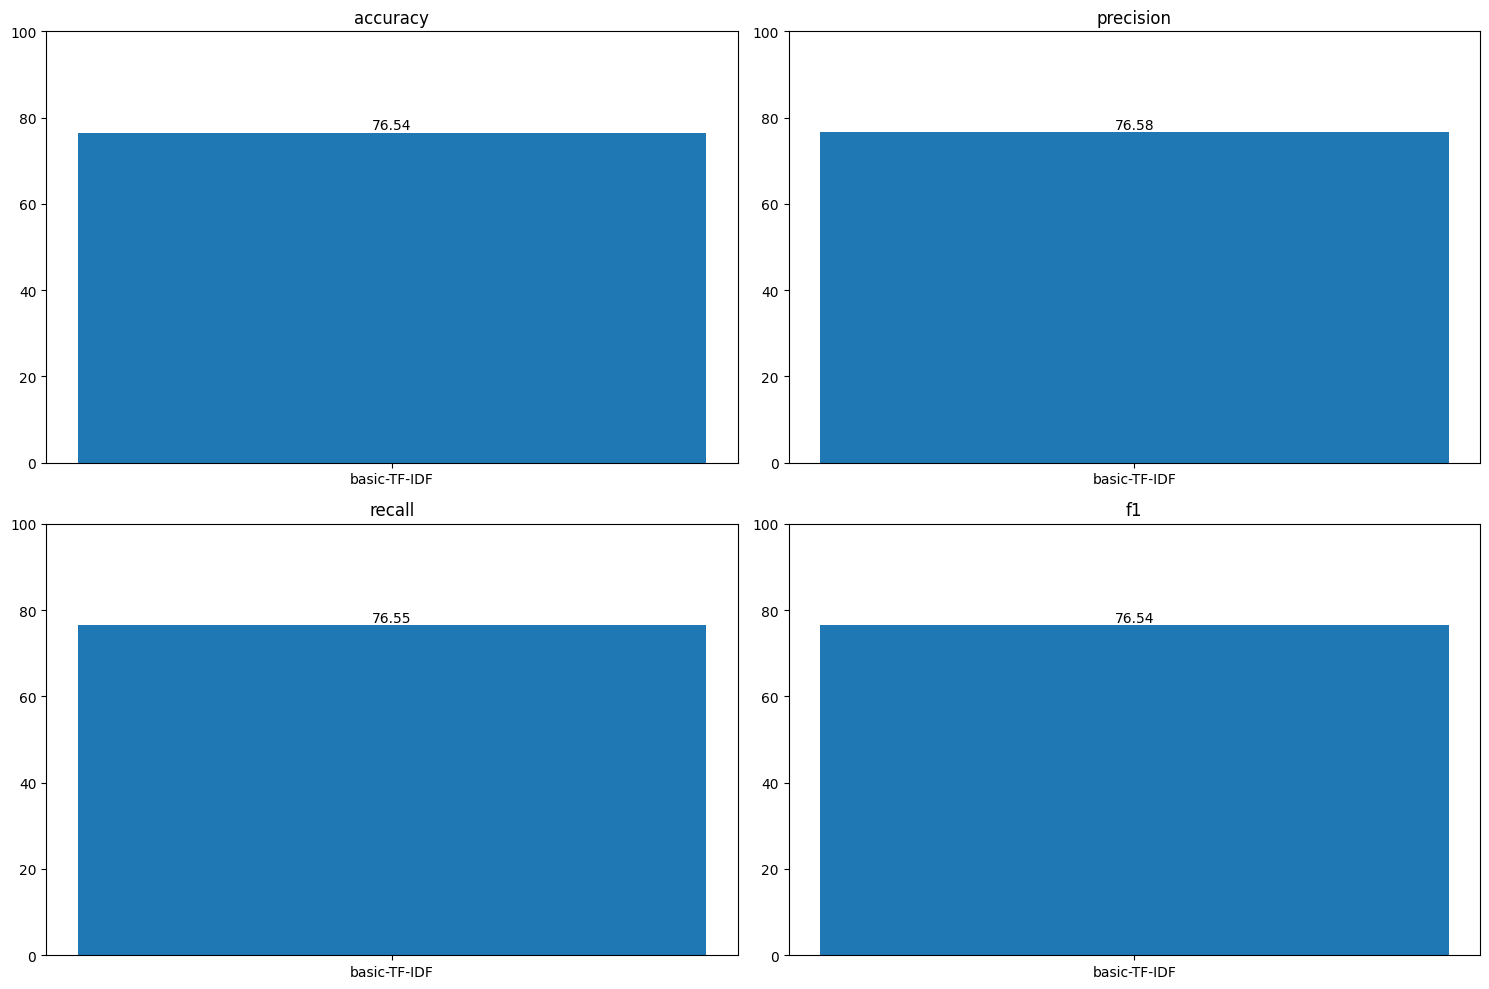

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Create a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Fit the pipeline on the training data
pipeline.fit(train_data, train_labels)

valid_preds = pipeline.predict(validation_data)

metrics_val= Metrics()
metrics_val.run(validation_labels, valid_preds, "basic-TF-IDF")
metrics_val.plot()